In [4]:
from src.models.uncertainty_module import UncertaintyModule
from src.models.slides_module import ViT8
from torch.optim import AdamW
import torch

model = UncertaintyModule.load_from_checkpoint("logs/train/runs/2023-01-05_09-04-11/checkpoints/epoch_066.ckpt").to("cuda:0")

Using cache found in /home/raa006/.cache/torch/hub/facebookresearch_dino_main
/home/raa006/.conda/envs/torch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (BrierScore). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/raa006/.conda/envs/torch/lib/python3.10/site-packages/to

In [5]:
from src.datasets.brain_dataset import BrainDataset
from src.datasets.upenn_dataset import UPennDataset
from src.datasets.ood_dataset import OodDataset
from src.datasets.cellphone_dataset import CellphoneDataset
import albumentations as A
from src.datamodules.brain_datamodule import BrainDataModule

%load_ext autoreload
%autoreload 2

ivygap_dataset = BrainDataset()
#upenn_dataset = UPennDataset(transform=A.Compose([A.Resize(224,224)]))
ood_dataset = OodDataset(ivygap_dataset, upenn_dataset)

# ivygap_datamodule = BrainDataModule()
# ivygap_datamodule.setup()

# ivygap_dataloader = ivygap_datamodule.train_dataloader()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# create a dataloader from oov_dataset
 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

dataloader = DataLoader(ood_dataset, batch_size=10, shuffle=True, num_workers=6)


In [7]:
# draw the ROC curve for the epistemic confidence 
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

model = model.to('cuda:0')

# Compute all the y_true and y_score_epistemic over the first 100 batches
y_true = []
y_score_epistemic = []
y_score_aleatoric = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        y_true.append(batch["id_data"].detach().numpy())
        y_score_epistemic.append(model.net.epistemic_confidence(batch["image"].to('cuda:0')).detach().cpu().numpy())
        y_score_aleatoric.append(model.net.aleatoric_confidence(batch["image"].to('cuda:0')).detach().cpu().numpy())
        if len(y_score_epistemic) == 200:
            break
y_true = np.concatenate(y_true)
y_score_epistemic = np.concatenate(y_score_epistemic)
y_score_aleatoric = np.concatenate(y_score_aleatoric)



  2%|▏         | 199/10187 [00:29<24:30,  6.79it/s] 


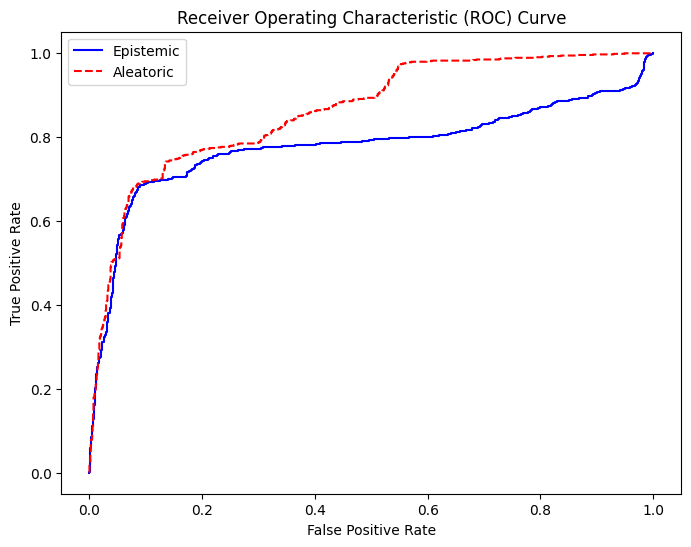

In [8]:
# Calculate ROC curve for epistemic confidence
fpr, tpr, thresholds = roc_curve(y_true, y_score_epistemic, pos_label=1)
plt.plot(fpr, tpr, color='blue', linestyle='solid', label='Epistemic')

# Calculate ROC curve for aleatoric confidence
fpr, tpr, thresholds = roc_curve(y_true, y_score_aleatoric, pos_label=1)
plt.plot(fpr, tpr, color='red', linestyle='dashed', label='Aleatoric')

# Add axis labels and a title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add legend
plt.legend()

# Increase figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

plt.show()


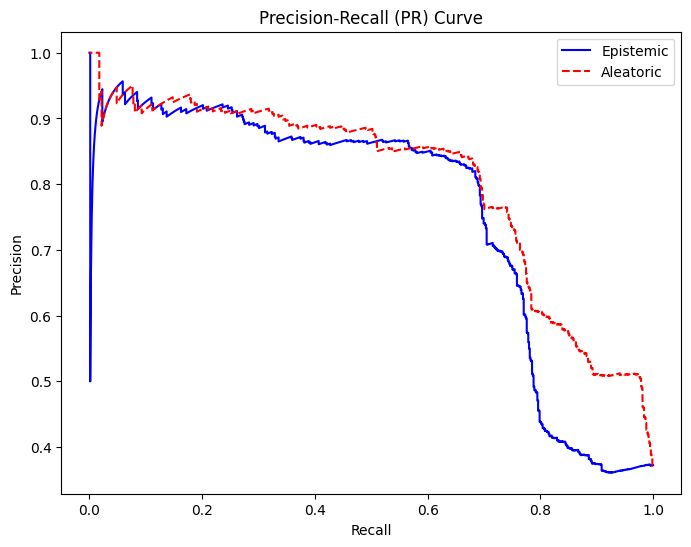

In [9]:
from sklearn.metrics import precision_recall_curve

# Calculate PR curve for epistemic confidence
precision, recall, thresholds = precision_recall_curve(y_true, y_score_epistemic, pos_label=1)
plt.plot(recall, precision, color='blue', linestyle='solid', label='Epistemic')

# Calculate PR curve for aleatoric confidence
precision, recall, thresholds = precision_recall_curve(y_true, y_score_aleatoric, pos_label=1)
plt.plot(recall, precision, color='red', linestyle='dashed', label='Aleatoric')

# Add axis labels and a title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')

# Add legend
plt.legend()

# Increase figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

plt.show()


In [11]:
from torchmetrics import MaxMetric, AUROC
from src.models.natpn.metrics.aucpr import AUCPR
from torch import tensor

aleatoric_confidence_auc_pr = AUCPR(compute_on_step=False)( tensor(y_score_aleatoric),tensor(y_true))
aleatoric_confidence_auc_roc = AUROC(compute_on_step=False)( tensor(y_score_aleatoric),tensor(y_true))
epistemic_confidence_auc_pr = AUCPR(compute_on_step=False)( tensor(y_score_epistemic),tensor(y_true))
epistemic_confidence_auc_roc = AUROC(compute_on_step=False)( tensor(y_score_epistemic),tensor(y_true))

# Print all the metrics
print("aleatoric_confidence_auc_pr", aleatoric_confidence_auc_pr.item())
print("aleatoric_confidence_auc_roc", aleatoric_confidence_auc_roc.item())
print("epistemic_confidence_auc_pr", epistemic_confidence_auc_pr.item())
print("epistmic_confidence_auc_roc", epistemic_confidence_auc_roc.item())

aleatoric_confidence_auc_pr 0.8027734756469727
aleatoric_confidence_auc_roc 0.8621321320533752
epistemic_confidence_auc_pr 0.7572019696235657
epistmic_confidence_auc_roc 0.777198314666748


/home/raa006/.conda/envs/torch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (AUCPR). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/raa006/.conda/envs/torch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all target